In [1]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
device = 'cuda'

c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

train_path = 'yeni data Final/yeni_train.csv'
test_path = 'yeni data Final/yeni_test.csv'
tremodata_path = 'TREMODATA.xml'

train = pd.read_csv(train_path)
train.rename(columns={'Sentence':'text', 'Label':'label'}, inplace=True)
train.drop(['Unnamed: 0'], inplace=True, axis='columns')

test = pd.read_csv(test_path)
test.rename(columns={'Sentence':'text', 'Label':'label'}, inplace=True)
test.drop(['Unnamed: 0'], inplace=True, axis='columns')


tremodata = pd.read_xml(tremodata_path)
tremodata = tremodata[tremodata['Condition'] == 'Consensus']
tremodata.drop(['ID', 'OriginalEmotion', 'Condition', 'VoteDistribution'], axis='columns', inplace=True)
tremodata.rename(columns={'Entry':'text', 'ValidatedEmotion':'label'}, inplace=True)
tremodata = tremodata.reset_index(drop=True)

frames = [train, test, tremodata]
df = pd.concat(frames)
df = df.reset_index(drop=True)


In [3]:
#ilk 10 veriyi göster
print(df.head(10))

                                                text     label
0  Sadece 1 Yýl içinde bunu gönderen kullanýcý ço...     merak
1  Bunu ben keÅfetmiÅtim haha Ã§ok eÄlendim Å...     mutlu
2  [adi] sevi?yorum. gerçekten istiyorum. ona oy ...       aþk
3  sevgi gönderiyorum. bunu yaþadýðýn için çok üz...       aþk
4                            üzgünüm, üzgün deðilim.     utanç
5      Murat Ã§ok Ã¼zdÃ¼n beni aÄlayacaÄÄ±m Åimdi   Ã¼zgÃ¼n
6  [i?si?m] hýzlý uyumak çok güzel. i?ki sarýþýn ...       aþk
7           Oha ciddi olamazsÄ±n neden bu kadar geÃ§   surpriz
8  Bunun ( £ ) pound cinsinden ne kadar olacaðýný...     merak
9  Bu takÄ±m her gol yediÄinde kel kafalÄ± baÅk...  kÄ±zgÄ±n


In [4]:
#label sayıları ve dağılımı
print(df['label'].value_counts())



label
aþk         5490
Happy       4416
utanç       4085
Sadness     3612
Fear        3349
Anger       3307
merak       3267
Disgust     2798
Surprise    1980
mutlu        800
Ã¼zgÃ¼n      800
surpriz      800
kÄ±zgÄ±n     800
korku        800
Name: count, dtype: int64


In [5]:
# Labeling concatenated dataframe
for i in df.index:
  if df.label.iloc[i] == 'surpriz' or df.label.iloc[i] == 'Surprise':
    df.at[i, 'label'] = 'surprise'
  elif df.label.iloc[i] == 'kızgın' or df.label.iloc[i] == 'Anger' or df.label.iloc[i] == 'kÄ±zgÄ±n':
    df.at[i, 'label'] = 'anger'
  elif df.label.iloc[i] == 'Happy' or df.label.iloc[i] == 'mutlu':
    df.at[i, 'label'] = 'joy'
  elif df.label.iloc[i] == 'üzgün' or df.label.iloc[i] == 'Sadness' or df.label.iloc[i] == 'Ã¼zgÃ¼n':
    df.at[i, 'label'] = 'sadness'
  elif df.label.iloc[i] == 'korku' or df.label.iloc[i] == 'Fear':
    df.at[i, 'label'] = 'fear'
  elif df.label.iloc[i] == 'Disgust':
    df.at[i, 'label'] = 'disgust'
  elif df.label.iloc[i] == 'merak':
    df.at[i, 'label'] = 'curiosity'
  elif df.label.iloc[i] == 'aşk' or df.label.iloc[i] == 'aþk':
    df.at[i, 'label'] = 'love'
  elif df.label.iloc[i] == 'utanç':
    df.at[i, 'label'] = 'shame'

In [6]:
#duygu cesidi ve sayisi
df.label.value_counts()

label
love         5490
joy          5216
sadness      4412
fear         4149
anger        4107
shame        4085
curiosity    3267
disgust      2798
surprise     2780
Name: count, dtype: int64

In [7]:
df.label.unique()

array(['curiosity', 'joy', 'love', 'shame', 'sadness', 'surprise',
       'anger', 'fear', 'disgust'], dtype=object)

In [8]:
# Preprocess text
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word == 'RT':
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        elif word.startswith('!') or word.startswith('&') or word.startswith('-'):
            continue
        else:
            final_text += word+' '
    return final_text

df['text'] = df['text'].apply(filter)
df

,text,label
0,Sadece 1 Yýl içinde bunu gönderen kullanýcý ço...,curiosity
1,Bunu ben keÅfetmiÅtim haha Ã§ok eÄlendim Å...,joy
2,[adi] sevi?yorum. gerçekten istiyorum. ona oy ...,love
3,sevgi gönderiyorum. bunu yaþadýðýn için çok üz...,love
4,"üzgünüm, üzgün deðilim.",shame
...,...,...
36299,Okuldan mezun olduğum an.,joy
36300,Biri bana bir işi nasıl yapmam gerektiğini söy...,anger
36301,Park halindeki arabama çarptıklarında.,anger
36302,Bardağımı başkasının kullanması.,disgust


In [9]:
df[df.label==8]

,text,label


In [10]:
#labellarin index karsiligini yazdirma
label2index = {label: i for i, label in enumerate(df.label.unique())}
index2label = {i: label for i, label in enumerate(df.label.unique())}
label2index
  


{'curiosity': 0,
 'joy': 1,
 'love': 2,
 'shame': 3,
 'sadness': 4,
 'surprise': 5,
 'anger': 6,
 'fear': 7,
 'disgust': 8}

In [11]:
# Converting labels to numerical
# 0: anger, 1: curiosity, 2: disgust, 3: fear, 4: joy, 5: love, 6: sadness, 7: shame, 8: surprise

for i in df.index:
    if df.label.iloc[i] == 'anger':
      df.at[i, 'label'] = 0
    elif df.label.iloc[i] == 'curiosity':
      df.at[i, 'label'] = 1
    elif df.label.iloc[i] == 'disgust':
      df.at[i, 'label'] = 2
    elif df.label.iloc[i] == 'fear':
      df.at[i, 'label'] = 3
    elif df.label.iloc[i] == 'joy':
      df.at[i, 'label'] = 4
    elif df.label.iloc[i] == 'love':
      df.at[i, 'label'] = 5
    elif df.label.iloc[i] == 'sadness':
      df.at[i, 'label'] = 6
    elif df.label.iloc[i] == 'shame':
      df.at[i, 'label'] = 7
    elif df.label.iloc[i] == 'surprise':
      df.at[i, 'label'] = 8


In [12]:
#ilk 10 satiri yazdir
df.head(10)

,text,label
0,Sadece 1 Yýl içinde bunu gönderen kullanýcý ço...,1
1,Bunu ben keÅfetmiÅtim haha Ã§ok eÄlendim Å...,4
2,[adi] sevi?yorum. gerçekten istiyorum. ona oy ...,5
3,sevgi gönderiyorum. bunu yaþadýðýn için çok üz...,5
4,"üzgünüm, üzgün deðilim.",7
5,Murat Ã§ok Ã¼zdÃ¼n beni aÄlayacaÄÄ±m Åimdi,6
6,[i?si?m] hýzlý uyumak çok güzel. i?ki sarýþýn ...,5
7,Oha ciddi olamazsÄ±n neden bu kadar geÃ§,8
8,Bunun ( £ ) pound cinsinden ne kadar olacaðýný...,1
9,Bu takÄ±m her gol yediÄinde kel kafalÄ± baÅk...,0


<Axes: >

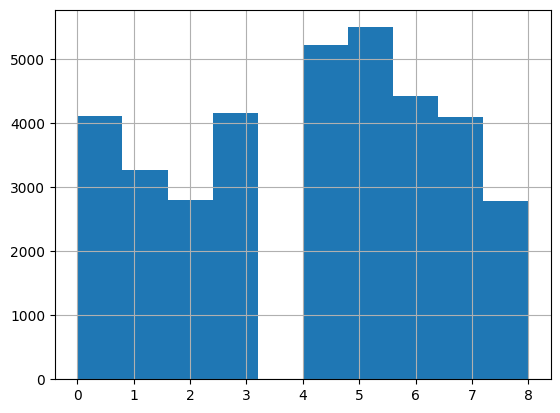

In [13]:
# Distribution of labels
df.label.hist()

In [14]:
# Shuffle dataset 
from sklearn.utils import shuffle
df = shuffle(df)

In [16]:
# Split data into train, test, valid
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
																	random_state = 42,
																	test_size = 0.2,
																	stratify = df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
																random_state = 42,
																test_size = 0.5,
																stratify = temp_labels)

In [17]:
# Import pretrained tokenizer and model from https://huggingface.co/maymuni/bert-base-turkish-cased-emotion-analysis?text=I+like+you.+I+love+you
tokenizer = AutoTokenizer.from_pretrained("maymuni/bert-base-turkish-cased-emotion-analysis")
bert = AutoModel.from_pretrained("maymuni/bert-base-turkish-cased-emotion-analysis",return_dict=False)

c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [20]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [22]:
class Arch(nn.Module):

    def __init__(self, bert):
      
      super(Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(512,9)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [23]:
device = torch.device('cuda')

# pass the pre-trained model to our define architecture
model = Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.0001)

c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.98204504 1.2345065  1.44191242 0.97228081 0.77330458 0.73474499
 0.91442335 0.9874541  1.45098921]


In [26]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 10

In [27]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>8,}  of  {:>8,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [28]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>8,}  of  {:>8,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [29]:
# Define Early Stopping Function
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

In [30]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train the model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'early_save.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping
    if early_stopping(train_loss, valid_loss, min_delta=10, tolerance = 20):
      print("We are at epoch:", epoch)
      break


 Epoch 1 / 10
  Batch       50  of       908.
  Batch      100  of       908.
  Batch      150  of       908.
  Batch      200  of       908.
  Batch      250  of       908.
  Batch      300  of       908.
  Batch      350  of       908.
  Batch      400  of       908.
  Batch      450  of       908.
  Batch      500  of       908.
  Batch      550  of       908.
  Batch      600  of       908.
  Batch      650  of       908.
  Batch      700  of       908.
  Batch      750  of       908.
  Batch      800  of       908.
  Batch      850  of       908.
  Batch      900  of       908.

Evaluating...
  Batch       50  of       114.
  Batch      100  of       114.

Training Loss: 0.944
Validation Loss: 0.682

 Epoch 2 / 10
  Batch       50  of       908.
  Batch      100  of       908.
  Batch      150  of       908.
  Batch      200  of       908.
  Batch      250  of       908.
  Batch      300  of       908.
  Batch      350  of       908.
  Batch      400  of       908.
  Batch      4

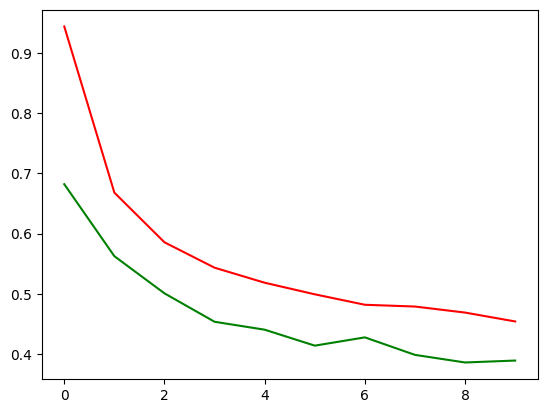

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r')
plt.plot(valid_losses, color='g')

In [32]:
# reduce the batch size for making predictions
batch_size = 16

# create a new data loader with reduced batch size
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# get predictions for test data with reduced batch size
with torch.no_grad():
  preds = []
  for batch in test_dataloader:
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    pred = model(sent_id, mask)
    preds.append(pred.detach().cpu().numpy())

# concatenate the predictions
preds = np.concatenate(preds, axis=0)

# Labeling
predicted_label = []
for pred in preds:
  predicted_label.append(np.argmax(pred))

In [33]:
from sklearn.metrics import classification_report
target_names = ['anger', 'curiosity', 'disgust', 'fear', 'joy', 'love', 'sadness', 'shame', 'surprise']
print(classification_report(test_y, predicted_label, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.90      0.85      0.87       411
   curiosity       0.91      0.78      0.84       326
     disgust       0.91      0.93      0.92       280
        fear       0.88      0.91      0.90       415
         joy       0.91      0.87      0.89       522
        love       0.87      0.85      0.86       549
     sadness       0.84      0.88      0.86       442
       shame       0.77      0.84      0.80       408
    surprise       0.84      0.91      0.88       278

    accuracy                           0.87      3631
   macro avg       0.87      0.87      0.87      3631
weighted avg       0.87      0.87      0.87      3631



In [34]:
# confusion matrix
pd.crosstab(test_y, predicted_label)

col_0,0,1,2,3,4,5,6,7,8
row_0,,,,,,,,,
0,349,3,12,5,5,2,27,2,6
1,1,254,0,6,3,15,1,32,14
2,6,0,259,5,2,0,6,1,1
3,6,0,8,376,6,1,13,1,4
4,2,1,1,10,455,21,18,3,11
5,1,5,1,5,3,467,2,64,1
6,9,5,1,7,18,1,391,1,9
7,10,9,3,10,0,29,2,344,1
8,3,1,1,1,8,2,8,1,253


In [35]:
import heapq

#Define predict function
def predict_emotion(text):
    tokenized = tokenizer.encode_plus(
        text,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']

    seq = torch.tensor(input_ids)
    mask = torch.tensor(attention_mask)
    seq = seq.unsqueeze(0)
    mask = mask.unsqueeze(0)
    preds = model(seq.to(device), mask.to(device))
    preds = preds.detach().cpu().numpy()
    preds = torch.tensor(preds)
    probabilities = nn.functional.softmax(preds)

    # Get the top 3 emotions by probability
    top3_emotions = heapq.nlargest(3, enumerate(probabilities[0]), key=lambda x: x[1])

    # Get the names and probabilities of the top 3 emotions
    top3_emotion_names = ['kızgın', 'üzgün', 'korku', 'iğrenme', 'mutlu', 'aşk', 'merak', 'utanç', 'şaşkınlık']
    top3_emotion_probabilities = {top3_emotion_names[index]: float(prob) for index, prob in top3_emotions}

    return top3_emotion_probabilities

#Usage example
top3_probabilities = predict_emotion("")
print("Top 3 Emotions:", top3_probabilities)

Top 3 Emotions: {'korku': 0.49301663041114807, 'iğrenme': 0.41798365116119385, 'mutlu': 0.040350090712308884}


c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\VERONICA\AppData\Local\Temp\ipykernel_18360\1498061613.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def get_prediction(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs

predict_emotion('çok mutluyum')

c:\Users\VERONICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\VERONICA\AppData\Local\Temp\ipykernel_18360\1498061613.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


{'mutlu': 0.7368144989013672,
 'aşk': 0.2420353889465332,
 'utanç': 0.01582074910402298}

In [38]:
#modeli kaydetme
torch.save(model.state_dict(), 'model_Final_son.pt')


In [39]:
# Modeli kaydet
tokenizer.save_pretrained('tokenizer_Final_son')

('tokenizer_Final_son\\tokenizer_config.json',
 'tokenizer_Final_son\\special_tokens_map.json',
 'tokenizer_Final_son\\vocab.txt',
 'tokenizer_Final_son\\added_tokens.json',
 'tokenizer_Final_son\\tokenizer.json')

In [62]:
#cumle ile modeli test edelim
model = Arch(bert)
model.load_state_dict(torch.load('model_Final_son.pt'))
model = model.to(device)

predict_emotion('çok mutluyum')

C:\Users\VERONICA\AppData\Local\Temp\ipykernel_18360\1498061613.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = nn.functional.softmax(preds)


{'mutlu': 0.783873438835144,
 'aşk': 0.20268450677394867,
 'utanç': 0.008600687608122826}